In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pymc3 as pm
import arviz as az


In [75]:
## Join data

features = pd.read_csv('data/dengue_features_train.csv')
labels   = pd.read_csv('data/dengue_labels_train.csv')

df = features.copy()

df['total_cases'] = labels.total_cases

# Target is in column 'total_cases'

In [76]:
df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [77]:
cities = list(df.city.unique())

sj_df = df.loc[df.city=='sj']

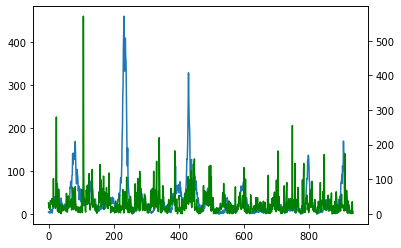

In [78]:
plt.plot()

ax1 = sj_df.total_cases.plot()
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))

sj_df.reanalysis_precip_amt_kg_per_m2.plot(ax=ax2, color='green')


plt.show()


In [236]:
sub_sj = sj_df.loc[0:50]

In [237]:
with pm.Model() as simple_model:
    b0 = pm.Normal("b0_intercept", mu=0, sigma=10)
    b1 = pm.Normal("b1_variable",  mu=0, sigma=10)
    b2 = pm.Normal("b2_variable",  mu=0, sigma=10)
    b3 = pm.Normal("b3_variable",  mu=0, sigma=10)
    b4 = pm.Normal("b4_variable",  mu=0, sigma=10)
    
    θ  = (
        b0
        + b1 * sub_sj.reanalysis_precip_amt_kg_per_m2
        + b2 * sub_sj.reanalysis_relative_humidity_percent
        + b3 * sub_sj.reanalysis_max_air_temp_k
        + b4 * sub_sj.station_precip_mm
    ) 
    
    y = pm.Poisson("y", mu=np.exp(θ), observed=sub_sj.total_cases)


In [238]:
with simple_model:
    step = pm.Slice()
    inf_model = pm.sample(100000, step=step, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [b4_variable]
>Slice: [b3_variable]
>Slice: [b2_variable]
>Slice: [b1_variable]
>Slice: [b0_intercept]


Sampling 4 chains for 1_000 tune and 100_000 draw iterations (4_000 + 400_000 draws total) took 157 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'b0_intercept'}>,
        <AxesSubplot:title={'center':'b0_intercept'}>],
       [<AxesSubplot:title={'center':'b1_variable'}>,
        <AxesSubplot:title={'center':'b1_variable'}>],
       [<AxesSubplot:title={'center':'b2_variable'}>,
        <AxesSubplot:title={'center':'b2_variable'}>],
       [<AxesSubplot:title={'center':'b3_variable'}>,
        <AxesSubplot:title={'center':'b3_variable'}>],
       [<AxesSubplot:title={'center':'b4_variable'}>,
        <AxesSubplot:title={'center':'b4_variable'}>]], dtype=object)

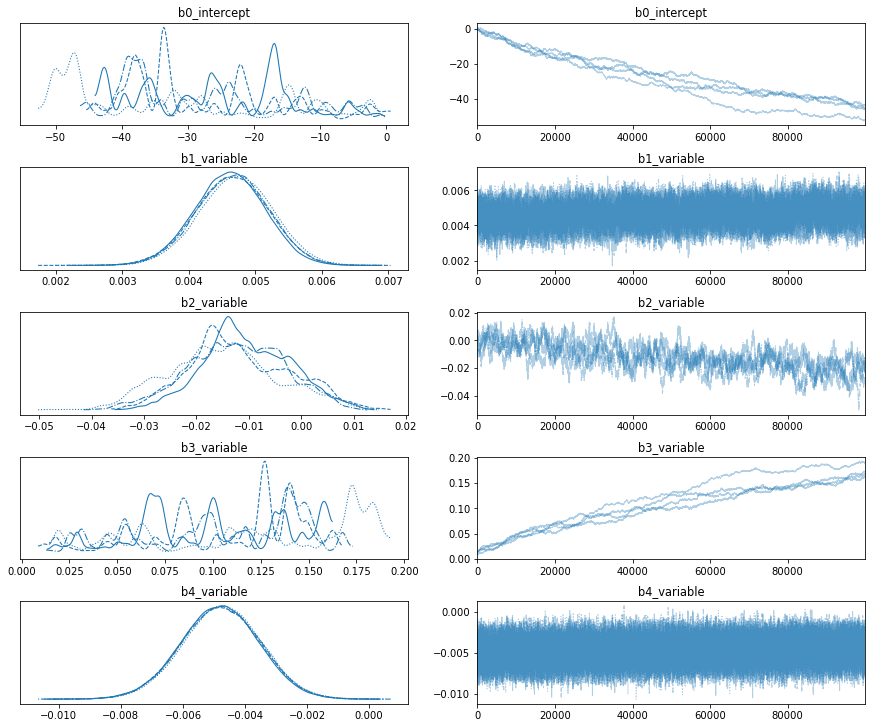

In [231]:
az.plot_trace(inf_model)

In [232]:
pm.find_MAP(model=simple_model)

{'b0_intercept': array(-0.00011452),
 'b1_variable': array(0.00450806),
 'b2_variable': array(-0.00027722),
 'b3_variable': array(0.01182261),
 'b4_variable': array(-0.00510735)}